In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving BTC-USD.csv to BTC-USD.csv
User uploaded file "BTC-USD.csv" with length 165035 bytes


In [0]:
df = pd.read_csv('BTC-USD.csv')

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2071 non-null   object 
 1   Open       2071 non-null   float64
 2   High       2071 non-null   float64
 3   Low        2071 non-null   float64
 4   Close      2071 non-null   float64
 5   Adj Close  2071 non-null   float64
 6   Volume     2071 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 113.4+ KB


In [0]:
group=  df.groupby("Date")
data = group["Close"].mean()

In [13]:
data.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

In [0]:
close_train = data.iloc[:len(data)-50]
close_test = data.iloc[len(close_train):]

In [0]:
#feature scalling (set values between 0-1)

In [0]:
close_train = np.array(close_train)

In [0]:
close_train = close_train.reshape(close_train.shape[0], 1)

In [17]:
close_train

array([[ 457.334015],
       [ 424.440002],
       [ 394.79599 ],
       ...,
       [6469.79834 ],
       [6242.193848],
       [5922.042969]])

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
close_scaled = scaler.fit_transform(close_train)

In [19]:
timestep = 50
x_train = []
y_train = []

for i in range(timestep, close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1) #reshaped for RNN
print("x_train shape = ", x_train.shape)
print("y_train shape = ", y_train.shape)

x_train shape =  (1971, 50, 1)
y_train shape =  (1971,)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Flatten

In [0]:
# Build Model

model = Sequential()

# 1st RNN layer
model.add(SimpleRNN(128, activation = 'relu', return_sequences= True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# 2nd  RNN layer
model.add(SimpleRNN(256, activation = 'relu', return_sequences= True))
model.add(Dropout(0.25))

# 3rd  RNN layer
model.add(SimpleRNN(512, activation = 'relu', return_sequences= True))
model.add(Dropout(0.35))

# 4th  RNN layer
model.add(SimpleRNN(256, activation = 'relu', return_sequences= True))
model.add(Dropout(0.25))

# 5th  RNN layer
model.add(SimpleRNN(128, activation = 'relu', return_sequences= True))
model.add(Dropout(0.25))

# Convert matrix to 1 = line
model.add(Flatten())

#output layer
model.add(Dense(1))


In [0]:
# Compile model

model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ['accuracy'])


In [23]:
# Run Model

model.fit(x_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
1971/1971 [==============================] - 11s 5ms/step - loss: 0.0595
Epoch 2/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0046
Epoch 3/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0032
Epoch 4/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0024
Epoch 5/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0020
Epoch 6/100
1971/1971 [==============================] - 9s 4ms/step - loss: 0.0019
Epoch 7/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0017
Epoch 8/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0015
Epoch 9/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0015
Epoch 10/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0013
Epoch 11/100
1971/1971 [==============================] - 8s 4ms/step - loss: 0.0012
Epoch 12/100
1971/1971 [==============================] - 8s 4ms/step - l

In [0]:
inputs = data[len(data) - len(close_test) - timestep:]
inputs = inputs.values.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [0]:
x_test = []
for i in range(timestep, inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [0]:
predicted_data = model.predict(x_test)
predicted_data = scaler.inverse_transform(predicted_data)

In [0]:
data_test = np.array(close_test)
data_test = data_test.reshape(len(data_test), 1)

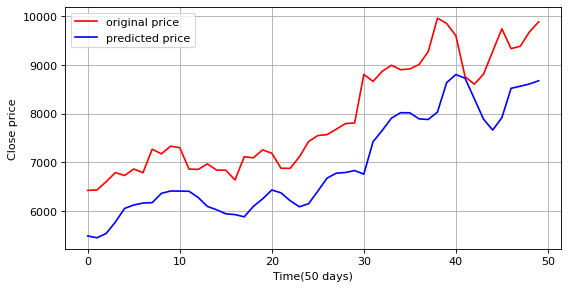

In [28]:
plt.figure(figsize = (8, 4), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(data_test, color = "r", label = "original price")
plt.plot(predicted_data, color = "b", label = "predicted price")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close price")
plt.grid(True)
plt.show()

# LSTM

In [0]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

In [0]:
# Build LSTM Model 

model = Sequential()

model.add(LSTM(10, input_shape = (None, 1), activation = "relu"))

model.add(Dense(1))

In [0]:
# Compile Model

model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['accuracy'])

In [32]:
# Run Model

model.fit(x_train, y_train, epochs=100, batch_size = 32)

Epoch 1/100
1971/1971 [==============================] - 10s 5ms/step - loss: 0.0761 - accuracy: 5.0736e-04
Epoch 2/100
1971/1971 [==============================] - 10s 5ms/step - loss: 0.0320 - accuracy: 5.0736e-04
Epoch 3/100
1971/1971 [==============================] - 10s 5ms/step - loss: 0.0140 - accuracy: 5.0736e-04
Epoch 4/100
1971/1971 [==============================] - 9s 5ms/step - loss: 0.0093 - accuracy: 0.0010
Epoch 5/100
1971/1971 [==============================] - 9s 5ms/step - loss: 0.0050 - accuracy: 0.0010
Epoch 6/100
1971/1971 [==============================] - 9s 5ms/step - loss: 0.0025 - accuracy: 0.0010
Epoch 7/100
1971/1971 [==============================] - 9s 5ms/step - loss: 0.0015 - accuracy: 0.0010
Epoch 8/100
1971/1971 [==============================] - 9s 5ms/step - loss: 0.0012 - accuracy: 0.0010
Epoch 9/100
1971/1971 [==============================] - 9s 5ms/step - loss: 9.5661e-04 - accuracy: 0.0010
Epoch 10/100
1971/1971 [==============================

In [0]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
predicted_data = model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

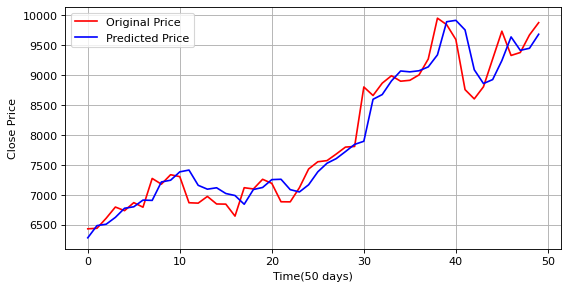

In [38]:
plt.figure(figsize = (8, 4), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(data_test, color = "r", label = "Original Price")
plt.plot(predicted_data, color = "b", label = "Predicted Price")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()